In [1]:
#Import dependencies - plotting
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import matplotlib.cbook as cbook

In [2]:
#Import dependencies - dataframe, computation, et.al.
import numpy as np
import pandas as pd
import re

In [3]:
#Import dependencies - date values and formats
import datetime as dt
from datetime import datetime
from datetime import date
from datetime import timedelta
import calendar

In [4]:
# Import dependencies - SQLalchemy
import sqlalchemy
from sqlalchemy import create_engine

# Step 1 - Climate Analysis and Exploration

### Use SQLalchemy to connect to sqlite database.

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

### Use Db Browser to preview the data model (to get a sense as to how the database is structured)
![Hawaii Preview](Images/hawaii_preview.png)

### Use python pandas to import and preview sqlite database tables

* Pandas method using pd.read_sql() method - next 3 cells
* Import the tables as DataFrames and merge them on the station column

In [6]:
# Import measurement table into DataFrame from database
measure_df = pd.read_sql('SELECT * FROM measurement', conn)
measure_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [7]:
# Import station table into DataFrame from database
station_df = pd.read_sql('SELECT * FROM station', conn)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [8]:
# Merge (outer) the 2 dataframes
df1 = measure_df.drop(columns='id')
df2 = station_df.drop(columns='id')
df = df1.merge(df2, on='station', how='outer')
df.head()

,station,date,prcp,tobs,name,latitude,longitude,elevation
0,USC00519397,2010-01-01,0.08,65.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00519397,2010-01-02,0.00,63.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00519397,2010-01-03,0.00,74.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,USC00519397,2010-01-04,0.00,76.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,USC00519397,2010-01-06,NaN,73.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [9]:
# Create a shadow datetime-format data column ("dt date") to mirror string-format date column
df["dt date"] = pd.to_datetime(df["date"])
df.head()

,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date
0,USC00519397,2010-01-01,0.08,65.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-01
1,USC00519397,2010-01-02,0.00,63.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-02
2,USC00519397,2010-01-03,0.00,74.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-03
3,USC00519397,2010-01-04,0.00,76.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-04
4,USC00519397,2010-01-06,NaN,73.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-06


In [10]:
# Check data types for each column
df.dtypes

station              object
date                 object
prcp                float64
tobs                float64
name                 object
latitude            float64
longitude           float64
elevation           float64
dt date      datetime64[ns]
dtype: object

### Precipitation Analysis

In [11]:
# Calculate the earliest and most recent dates in the database
start_date_str = str(df['dt date'].min()).split(" ")[0]
end_date_str = str(df['dt date'].max()).split(" ")[0]
print(f" The earliest date in the dataset is {start_date_str}")
print(f" The most recent date in the dataset is {end_date_str}")

# Calculate the date 1 year ago from the last data point in the database
yr_before_date = df["dt date"].max() - pd.offsets.DateOffset(years=1)
yr_before_date_str = str(yr_before_date).split(" ")[0]
print(f" The year-before date for the most recent date in the dataset is {yr_before_date_str}")

 The earliest date in the dataset is 2010-01-01
 The most recent date in the dataset is 2017-08-23
 The year-before date for the most recent date in the dataset is 2016-08-23


### Pandas-heavy method for query retrieving last 12 months of precipitation data

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results (plot further down)
df02 = df.loc[df['dt date'] > yr_before_date].reset_index()
print(f"\n Pandas-heavy method returns {len(df02)} records (rows) for LTM precipitation data.")
df02.head()


 Pandas-heavy method returns 2223 records (rows) for LTM precipitation data.


,index,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date
0,2364,USC00519397,2016-08-24,0.08,79.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-24
1,2365,USC00519397,2016-08-25,0.08,80.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-25
2,2366,USC00519397,2016-08-26,0.00,79.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-26
3,2367,USC00519397,2016-08-27,0.00,77.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-27
4,2368,USC00519397,2016-08-28,0.01,78.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-28


### SQL-heavy method for query retrieving last 12 months of precipitation data

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results  (plot further down)
# Select only the date and prcp values.  NOTE: We chose to ignore for utility.
sql_df = pd.read_sql("SELECT m.station, m.date, m.prcp, m.tobs, s.name, s.latitude, s.longitude, s.elevation \
                     FROM measurement m JOIN station s ON m.station = s.station \
                     WHERE m.date > '2016-08-23'", conn)
sql_df["dt date"] = pd.to_datetime(sql_df["date"])
print(f"\n SQL-heavy method returns {len(sql_df)} records (rows) for LTM precipitation data.")
sql_df.head()


 SQL-heavy method returns 2223 records (rows) for LTM precipitation data.


,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date
0,USC00519397,2016-08-24,0.08,79.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-24
1,USC00519397,2016-08-25,0.08,80.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-25
2,USC00519397,2016-08-26,0.00,79.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-26
3,USC00519397,2016-08-27,0.00,77.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-27
4,USC00519397,2016-08-28,0.01,78.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-28


### Calculate the number of rows with Null value and return them.

In [14]:
# Return records with null values across all columns
df02na = df02[df02.isna().any(axis=1)]
print(f"\n The number of rows with Null value in Any Column = {len(df02na)}")
df02na.head()


 The number of rows with Null value in Any Column = 208


,index,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date
12,2376,USC00519397,2016-09-05,NaN,79.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-09-05
13,2377,USC00519397,2016-09-06,NaN,76.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-09-06
708,7337,USC00514830,2016-08-31,NaN,80.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,2016-08-31
711,7340,USC00514830,2016-09-05,NaN,82.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,2016-09-05
716,7345,USC00514830,2016-09-12,NaN,79.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,2016-09-12


In [15]:
# Return records with null values for just the Precipitation Column
df02nap = df02[df02["prcp"].isnull()]
print(f"\n The number of rows with Null value in the Precipitation (prcp) Column = {len(df02nap)}")
df02nap.head()


 The number of rows with Null value in the Precipitation (prcp) Column = 208


,index,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date
12,2376,USC00519397,2016-09-05,NaN,79.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-09-05
13,2377,USC00519397,2016-09-06,NaN,76.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-09-06
708,7337,USC00514830,2016-08-31,NaN,80.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,2016-08-31
711,7340,USC00514830,2016-09-05,NaN,82.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,2016-09-05
716,7345,USC00514830,2016-09-12,NaN,79.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,2016-09-12


In [16]:
# Return records with null values for just the Temperature Column
df02nat = df02[df02["tobs"].isnull()]
print(f"\n The number of rows with Null value in the Temperature (tobs) Column = {len(df02nat)}")
df02nat.head()


 The number of rows with Null value in the Temperature (tobs) Column = 0


,index,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date


In [17]:
# for inspection purposes
# pd.set_option('display.max_rows', None) 

### Pandas-oriented query to extract number of weather stations, their names, and their IDs.

In [18]:
# Design a query to show how many stations are available in this dataset - pandas method
print(f"For the full data set, data was collected from {station_df['name'].nunique()} Weather Stations.")
print(f"However, for the most recent 12 months, data was collected from {df02['name'].nunique()} Weather Stations.")

For the full data set, data was collected from 9 Weather Stations.
However, for the most recent 12 months, data was collected from 7 Weather Stations.


In [19]:
# Design a query to show a list of stations in this dataset - pandas method
name_list = station_df['name'].unique()
name_list

array(['WAIKIKI 717.2, HI US', 'KANEOHE 838.1, HI US',
       'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'PEARL CITY, HI US',
       'UPPER WAHIAWA 874.3, HI US', 'WAIMANALO EXPERIMENTAL FARM, HI US',
       'WAIHEE 837.5, HI US', 'HONOLULU OBSERVATORY 702.2, HI US',
       'MANOA LYON ARBO 785.2, HI US'], dtype=object)

In [20]:
# Clean up and list weather station names -- sort of improving utility - pandas method
name_list = station_df["name"].unique()
improved_name_list = []
for name in name_list:
    name1 = name.title()
    name2 = name1.replace(" ", "")
    name3 = re.search(r"[a-zA-Z]*", name2).group()
    name4 = re.sub(r"(?<=\w)([A-Z])", r" \1", name3)
    improved_name_list.append(name4)
print(f"Weather Stations include {improved_name_list}.")

Weather Stations include ['Waikiki', 'Kaneohe', 'Kualoa Ranch Headquarters', 'Pearl City', 'Upper Wahiawa', 'Waimanalo Experimental Farm', 'Waihee', 'Honolulu Observatory', 'Manoa Lyon Arbo'].


In [21]:
# Extract unique weather station ids - pandas method
station_ids_list = station_df['station'].unique().tolist()
print(f"The respective weather station IDs are as follows: {station_ids_list}.")

The respective weather station IDs are as follows: ['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918', 'USC00516128'].


### SQL-oriented query to extract number of weather stations

In [22]:
# Design a query to show how many stations are available in this dataset - SQL method
no_stations_sql = pd.read_sql('SELECT COUNT (DISTINCT s.name) FROM measurement m JOIN station s ON m.station = s.station', conn)
no_stations = pd.DataFrame(no_stations_sql).iloc[0,0]
print(f"For the full data set, data was collected from {no_stations} Weather Stations.")

no_stations_12mo_sql = pd.read_sql("SELECT COUNT (DISTINCT s.name) FROM measurement m JOIN station s \
                                   ON m.station = s.station WHERE m.date > '2016-08-23'", conn)
no_stations_12mo = pd.DataFrame(no_stations_12mo_sql).iloc[0,0]
print(f"However, for the most recent 12 months, data was collected from {no_stations_12mo} Weather Stations.")

For the full data set, data was collected from 9 Weather Stations.
However, for the most recent 12 months, data was collected from 7 Weather Stations.


In [23]:
# Design a query to show a list of stations in this dataset - SQL method
name_list_sql = pd.read_sql('SELECT DISTINCT s.name FROM measurement m JOIN station s ON m.station = s.station', conn)
name_list_sql = name_list_sql["name"].tolist()

# Clean up
improved_name_list_sql = []
for name in name_list_sql:
    name1 = name.title()
    name2 = name1.replace(" ", "")
    name3 = re.search(r"[a-zA-Z]*", name2).group()
    name4 = re.sub(r"(?<=\w)([A-Z])", r" \1", name3)
    improved_name_list_sql.append(name4)
print(f"Weather Stations include {improved_name_list_sql}.")

Weather Stations include ['Waikiki', 'Kaneohe', 'Kualoa Ranch Headquarters', 'Pearl City', 'Upper Wahiawa', 'Waimanalo Experimental Farm', 'Waihee', 'Honolulu Observatory', 'Manoa Lyon Arbo'].


In [24]:
# Extract unique weather station ids - SQL method
station_ids_list_sql = pd.read_sql('SELECT DISTINCT s.station FROM measurement m JOIN station s ON m.station = s.station', conn)
station_ids_list_sql = station_ids_list_sql["station"].tolist()
print(f"The respective weather station IDs are as follows: {station_ids_list_sql}.")

The respective weather station IDs are as follows: ['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918', 'USC00516128'].


### Use pandas to reshape DataFrame -- presenting precipitation data by weather station

In [25]:
# Create DataFrame labels
df_list = []
for name01 in improved_name_list:
    name02 = name01.replace(" ", "")
    x1 = f"{name02.lower()}_df"
    df_list.append(x1)
df_list

['waikiki_df',
 'kaneohe_df',
 'kualoaranchheadquarters_df',
 'pearlcity_df',
 'upperwahiawa_df',
 'waimanaloexperimentalfarm_df',
 'waihee_df',
 'honoluluobservatory_df',
 'manoalyonarbo_df']

In [26]:
# Create a dataframe to serve up query values for an iterrows call
query_list = {"Station ID": station_ids_list, "Station Name": improved_name_list, "DF Name List": df_list}
query_df = pd.DataFrame(query_list)
query_df

,Station ID,Station Name,DF Name List
0,USC00519397,Waikiki,waikiki_df
1,USC00513117,Kaneohe,kaneohe_df
2,USC00514830,Kualoa Ranch Headquarters,kualoaranchheadquarters_df
3,USC00517948,Pearl City,pearlcity_df
4,USC00518838,Upper Wahiawa,upperwahiawa_df
5,USC00519523,Waimanalo Experimental Farm,waimanaloexperimentalfarm_df
6,USC00519281,Waihee,waihee_df
7,USC00511918,Honolulu Observatory,honoluluobservatory_df
8,USC00516128,Manoa Lyon Arbo,manoalyonarbo_df


In [27]:
# Create and preview DataFrames for precipitation and date data from each weather station
for index, row in query_df.iterrows():
      
    row["DF Name List"] = df02[["date","dt date", "prcp"]].loc[df02["station"] == row["Station ID"]]
    row["DF Name List"] = row["DF Name List"].rename(columns={"prcp": f"{row['Station Name'].lower()} prcp"})
    print(f"Preview of {row['Station Name']}:\n")
    print(row["DF Name List"].head())
    print(f"Rows = {len(row['DF Name List'])}")
    print()    

Preview of Waikiki:

         date    dt date  waikiki prcp
0  2016-08-24 2016-08-24          0.08
1  2016-08-25 2016-08-25          0.08
2  2016-08-26 2016-08-26          0.00
3  2016-08-27 2016-08-27          0.00
4  2016-08-28 2016-08-28          0.01
Rows = 360

Preview of Kaneohe:

           date    dt date  kaneohe prcp
360  2016-08-24 2016-08-24          2.15
361  2016-08-25 2016-08-25          0.08
362  2016-08-26 2016-08-26          0.03
363  2016-08-27 2016-08-27          0.18
364  2016-08-28 2016-08-28          0.14
Rows = 342

Preview of Kualoa Ranch Headquarters:

           date    dt date  kualoa ranch headquarters prcp
702  2016-08-24 2016-08-24                            2.28
703  2016-08-25 2016-08-25                            0.00
704  2016-08-26 2016-08-26                            0.02
705  2016-08-27 2016-08-27                            0.02
706  2016-08-28 2016-08-28                            0.14
Rows = 304

Preview of Pearl City:

            date    dt da

In [28]:
# Create dataframe merging the individual weather station dataframes precipitation data on date
# NOTE: The query_df DataFrame was used to query for data for one weather station at a time
df001 = (query_df.iloc[0,2]).merge((query_df.iloc[1,2]), on=['date', 'dt date'], how='outer')
df001 = df001.merge((query_df.iloc[2,2]), on=['date', 'dt date'], how='outer')
df001 = df001.merge((query_df.iloc[3,2]), on=['date', 'dt date'], how='outer')
df001 = df001.merge((query_df.iloc[4,2]), on=['date', 'dt date'], how='outer')
df001 = df001.merge((query_df.iloc[5,2]), on=['date', 'dt date'], how='outer')
df001 = df001.merge((query_df.iloc[6,2]), on=['date', 'dt date'], how='outer')
df001 = df001.merge((query_df.iloc[7,2]), on=['date', 'dt date'], how='outer')
df001 = df001.merge((query_df.iloc[8,2]), on=['date', 'dt date'], how='outer')

# Set the index (again) as the datetime-type column (vs. the string-type date column)
# Sort the dataframe on the string-type date column
df001.set_index("dt date", inplace=True)
df001.sort_values(by=["date"], inplace=True)

#Preview
df001.head()

,date,waikiki prcp,kaneohe prcp,kualoa ranch headquarters prcp,pearl city prcp,upper wahiawa prcp,waimanalo experimental farm prcp,waihee prcp,honolulu observatory prcp,manoa lyon arbo prcp
dt date,,,,,,,,,,
2016-08-24,2016-08-24,0.08,2.15,2.28,NaN,NaN,1.22,2.15,NaN,1.45
2016-08-25,2016-08-25,0.08,0.08,0.00,0.00,NaN,0.21,0.06,NaN,0.11
2016-08-26,2016-08-26,0.00,0.03,0.02,0.04,NaN,0.00,0.01,NaN,NaN
2016-08-27,2016-08-27,0.00,0.18,0.02,NaN,NaN,0.00,0.12,NaN,NaN
2016-08-28,2016-08-28,0.01,0.14,0.14,NaN,NaN,0.14,0.60,NaN,2.07


In [29]:
# Check for duplicate dates
df001.duplicated(subset=['date']).value_counts()

False    365
dtype: int64

### Calculate number of precipitation measurements by each weather station and list in descending order

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_precip_measure_count = df001.count()
station_precip_measure_count_df = pd.DataFrame(station_precip_measure_count)
station_precip_measure_count_df.drop(station_precip_measure_count_df.index[0], inplace=True)
station_precip_measure_count_df.reset_index(inplace=True)
station_precip_measure_count_df.rename(columns={0: "Precip Measure Count", "index": "Weather Station"}, inplace=True)
station_precip_measure_count_df.sort_values(by=["Precip Measure Count"], ascending=False, inplace=True)

station_precip_measure_count_df

,Weather Station,Precip Measure Count
0,waikiki prcp,358
6,waihee prcp,351
1,kaneohe prcp,342
8,manoa lyon arbo prcp,327
5,waimanalo experimental farm prcp,313
2,kualoa ranch headquarters prcp,264
3,pearl city prcp,60
4,upper wahiawa prcp,0
7,honolulu observatory prcp,0


### Calculate average precipitation across all weather stations for each day

In [31]:
# Calculate average precipitation for all weather stations, capturing results to 2 series
average = []
date2 = []

for index, row in df001.iterrows():
    y = row.iloc[1:9].mean(skipna=True)
    average.append(y)
    date2.append(row["date"])
    
print(f"Values count for the mean calculation list {len(average)}")
print(f"Values count for the date list {len(date2)}")

Values count for the mean calculation list 365
Values count for the date list 365


In [32]:
# Create a dictionary to pull together the results from the 2 processed lists (cell above) into a DataFrame
avg_dict = {"date": date2, "average": average}
df002 = pd.DataFrame(avg_dict)
df002.head()

,date,average
0,2016-08-24,1.576000
1,2016-08-25,0.071667
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.206000


In [33]:
# Take column (average) from one DataFrame and insert it into another
df001["average"] = df002["average"].tolist()
df001.head()

,date,waikiki prcp,kaneohe prcp,kualoa ranch headquarters prcp,pearl city prcp,upper wahiawa prcp,waimanalo experimental farm prcp,waihee prcp,honolulu observatory prcp,manoa lyon arbo prcp,average
dt date,,,,,,,,,,,
2016-08-24,2016-08-24,0.08,2.15,2.28,NaN,NaN,1.22,2.15,NaN,1.45,1.576000
2016-08-25,2016-08-25,0.08,0.08,0.00,0.00,NaN,0.21,0.06,NaN,0.11,0.071667
2016-08-26,2016-08-26,0.00,0.03,0.02,0.04,NaN,0.00,0.01,NaN,NaN,0.016667
2016-08-27,2016-08-27,0.00,0.18,0.02,NaN,NaN,0.00,0.12,NaN,NaN,0.064000
2016-08-28,2016-08-28,0.01,0.14,0.14,NaN,NaN,0.14,0.60,NaN,2.07,0.206000


### Summary statistics for the precipitation data

In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_description = df001.describe(include=[np.number])
df_description1 = pd.DataFrame(df_description)
df_description1.rename(columns={"average": "Avg Across All Stations"}, inplace=True)
df_description1

,waikiki prcp,kaneohe prcp,kualoa ranch headquarters prcp,pearl city prcp,upper wahiawa prcp,waimanalo experimental farm prcp,waihee prcp,honolulu observatory prcp,manoa lyon arbo prcp,Avg Across All Stations
count,358.000000,342.000000,264.000000,60.000000,0.0,313.000000,351.000000,0.0,327.000000,365.000000
mean,0.044944,0.141404,0.125720,0.076500,NaN,0.121374,0.194416,NaN,0.449878,0.117900
std,0.189059,0.341744,0.316856,0.317857,NaN,0.509785,0.411050,NaN,0.718140,0.268107
min,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.010000,0.005000
50%,0.000000,0.030000,0.020000,0.000000,NaN,0.000000,0.060000,NaN,0.180000,0.035000
75%,0.020000,0.117500,0.120000,0.025000,NaN,0.060000,0.185000,NaN,0.605000,0.100000
max,2.620000,2.900000,2.390000,2.400000,NaN,6.250000,2.980000,NaN,6.700000,2.094000


In [35]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df03 = df001[["average", "date"]].sort_values(by=["date"])
df03.rename(columns={"average": "Precip Avg Across All Stations", "date": "Date"}, inplace=True)
df03.head()

,Precip Avg Across All Stations,Date
dt date,,
2016-08-24,1.576000,2016-08-24
2016-08-25,0.071667,2016-08-25
2016-08-26,0.016667,2016-08-26
2016-08-27,0.064000,2016-08-27
2016-08-28,0.206000,2016-08-28


### Plot results with MatPlotLib and Pandas

In [ ]:
# Calculate max y-axis value and add a 10% buffer
yaxis_max = df03["Precip Avg Across All Stations"].max() * 1.1
yaxis_max

In [ ]:
date = df03["Date"]
precip = df03["Precip Avg Across All Stations"]

In [ ]:
fig = plt.figure(figsize=(8,5))

x = [dt.datetime(2010, 12, 1, 10, 0),
    dt.datetime(2011, 1, 4, 9, 0),
    dt.datetime(2011, 5, 5, 9, 0)]
y = [4, 9, 2]

ax = plt.subplot(111)
ax.bar(x, y, width=10)
ax.xaxis_date()

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,5))

x = date
y = precip

ax = plt.subplot(111)
ax.bar(x, y, width=10)
ax.xaxis_date()

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,5))

# years = mdates.YearLocator()  
months = mdates.MonthLocator() 
# years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%Y-%m-%d')

date = df03["Date"]
precip = df03["Precip Avg Across All Stations"]

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()
ax.plot('date', 'precip') #, ax=ax)

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
# ax.xaxis.set_minor_locator(months)

# round to nearest years.
# datemin = np.datetime64(data['date'][0], 'Y')
# datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
datemin = df03["Date"].min()
datemax = df03["Date"].max()
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

In [ ]:
# Use Pandas Plotting with Matplotlib to plot the data

x = df03["Date"]
y = df03["Precip Avg Across All Stations"]


# x_pos = [i for i, _ in enumerate(x)]

plt.bar(x, y, color='red')
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title(f"Daily Precipitation in Hawaii \n Average Across 7 Weather Stations \n({yr_before_date} - {df['dt date'].max()})")

# plt.xticks(x_pos, x)

months = mdates.MonthLocator()  
ax.xaxis.set_major_locator(months)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.show()


In [ ]:
# Artifact from previous effort

max_prcp = graph_df1["prcp"].max()
min_prcp = graph_df1["prcp"].max()
avg_prcp = graph_df1["prcp"].mean()
avg_prcp = graph_df1["prcp"].median()

q1_prcp = graph_df1.quantile(0.25, numeric_only=True)
q2_prcp = graph_df1.quantile(0.5, numeric_only=True)
q3_prcp = graph_df1.quantile(0.75, numeric_only=True)

std_prcp = graph_df1["prcp"].std()


max_prcp

### Analyze temperature measurements for each weather station - Most Recent 12 Months
* Design a query to retrieve the last 12 months of temperature observation data (TOBS).

In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# Using temperature observation data (TOBS)


In [37]:
# Create and preview DataFrames for temperature and date data from each weather station
for index, row in query_df.iterrows():
      
    row["DF Name List"] = df02[["date","dt date", "tobs"]].loc[df02["station"] == row["Station ID"]]
    row["DF Name List"] = row["DF Name List"].rename(columns={"tobs": f"{row['Station Name'].lower()} temp"})
    print(f"Preview of {row['Station Name']}:\n")
    print(row["DF Name List"].head())
    print(f"Rows = {len(row['DF Name List'])}")
    print()

Preview of Waikiki:

         date    dt date  waikiki temp
0  2016-08-24 2016-08-24          79.0
1  2016-08-25 2016-08-25          80.0
2  2016-08-26 2016-08-26          79.0
3  2016-08-27 2016-08-27          77.0
4  2016-08-28 2016-08-28          78.0
Rows = 360

Preview of Kaneohe:

           date    dt date  kaneohe temp
360  2016-08-24 2016-08-24          76.0
361  2016-08-25 2016-08-25          77.0
362  2016-08-26 2016-08-26          78.0
363  2016-08-27 2016-08-27          73.0
364  2016-08-28 2016-08-28          73.0
Rows = 342

Preview of Kualoa Ranch Headquarters:

           date    dt date  kualoa ranch headquarters temp
702  2016-08-24 2016-08-24                            80.0
703  2016-08-25 2016-08-25                            81.0
704  2016-08-26 2016-08-26                            81.0
705  2016-08-27 2016-08-27                            81.0
706  2016-08-28 2016-08-28                            81.0
Rows = 304

Preview of Pearl City:

            date    dt da

In [38]:
# Create dataframe merging the individual weather station dataframes temperature data on date
# Reminder: The query_df DataFrame was used to query for data for one weather station at a time
df003 = (query_df.iloc[0,2]).merge((query_df.iloc[1,2]), on=['date', 'dt date'], how='outer')
df003 = df003.merge((query_df.iloc[2,2]), on=['date', 'dt date'], how='outer')
df003 = df003.merge((query_df.iloc[3,2]), on=['date', 'dt date'], how='outer')
df003 = df003.merge((query_df.iloc[4,2]), on=['date', 'dt date'], how='outer')
df003 = df003.merge((query_df.iloc[5,2]), on=['date', 'dt date'], how='outer')
df003 = df003.merge((query_df.iloc[6,2]), on=['date', 'dt date'], how='outer')
df003 = df003.merge((query_df.iloc[7,2]), on=['date', 'dt date'], how='outer')
df003 = df003.merge((query_df.iloc[8,2]), on=['date', 'dt date'], how='outer')

# Set the index (again) as the datetime-type column (vs. the string-type date column)
# Sort the dataframe on the string-type date column
df003.set_index("dt date", inplace=True)
df003.sort_values(by=["date"], inplace=True)

#Preview
df003.head()

,date,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp
dt date,,,,,,,,,,
2016-08-24,2016-08-24,79.0,76.0,80.0,78.0,NaN,79.0,77.0,NaN,74.0
2016-08-25,2016-08-25,80.0,77.0,81.0,81.0,NaN,80.0,80.0,NaN,77.0
2016-08-26,2016-08-26,79.0,78.0,81.0,81.0,NaN,84.0,80.0,NaN,NaN
2016-08-27,2016-08-27,77.0,73.0,81.0,NaN,NaN,81.0,75.0,NaN,74.0
2016-08-28,2016-08-28,78.0,73.0,81.0,NaN,NaN,80.0,73.0,NaN,71.0


### Calculate number of temperature measurements by each weather station and list in descending order - Most Recent 12 Months

In [39]:
station_temp_measure_count = df003.count()
station_temp_measure_count_df = pd.DataFrame(station_temp_measure_count)
station_temp_measure_count_df.drop(station_temp_measure_count_df.index[0], inplace=True)
station_temp_measure_count_df.reset_index(inplace=True)
station_temp_measure_count_df.rename(columns={0: "Temp Measure Count", "index": "Weather Station"}, inplace=True)
station_temp_measure_count_df.sort_values(by=["Temp Measure Count"], ascending=False, inplace=True)

station_temp_measure_count_df

,Weather Station,Temp Measure Count
0,waikiki temp,360
6,waihee temp,351
8,manoa lyon arbo temp,348
1,kaneohe temp,342
5,waimanalo experimental farm temp,336
2,kualoa ranch headquarters temp,304
3,pearl city temp,182
4,upper wahiawa temp,0
7,honolulu observatory temp,0


### Determine which weather station reported the highest number of temperature observations in the period - Most Recent 12 Months

In [40]:
# Choose the station with the highest number of temperature observations.
top_temp_measure_station = station_temp_measure_count_df.\
iloc[station_temp_measure_count_df['Temp Measure Count'].argmax()].tolist()

x = top_temp_measure_station[0]
x = x.split(" ")
x = x[:-1]                   # Removes the word "temp" which is common at the end of all possible values
x = " ".join(x)              # Rejoins the string with spaces if necessary, and now without the word "temp"
x = x.title()                # Title formats each word in the string

print(f"\nThe {x} Weather Station reported {top_temp_measure_station[1]} temperature observations. \
\nThis was the highest number for any of its Hawaiian Island peers during the period.")


The Waikiki Weather Station reported 360 temperature observations. 
This was the highest number for any of its Hawaiian Island peers during the period.


### Calculate average temperature (tobs) across all weather stations for each day - Most Recent 12 Months

In [41]:
# Calculate average TOBS for all weather stations
average = []
date2 = []

for index, row in df003.iterrows():
    y = row.iloc[1:9].mean(skipna=True)
    average.append(y)
    date2.append(row["date"])
    
print(f"Values count for the mean calculation list {len(average)}")
print(f"Values count for the date list {len(date2)}")

Values count for the mean calculation list 365
Values count for the date list 365


In [42]:
avg_dict = {"date": date2, "average": average}
df004 = pd.DataFrame(avg_dict)
df004.head()

,date,average
0,2016-08-24,78.166667
1,2016-08-25,79.833333
2,2016-08-26,80.500000
3,2016-08-27,77.400000
4,2016-08-28,77.000000


In [43]:
# Add average column to the larger dataframe
df003["average"] = df004["average"].tolist()
df003.head()

,date,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp,average
dt date,,,,,,,,,,,
2016-08-24,2016-08-24,79.0,76.0,80.0,78.0,NaN,79.0,77.0,NaN,74.0,78.166667
2016-08-25,2016-08-25,80.0,77.0,81.0,81.0,NaN,80.0,80.0,NaN,77.0,79.833333
2016-08-26,2016-08-26,79.0,78.0,81.0,81.0,NaN,84.0,80.0,NaN,NaN,80.500000
2016-08-27,2016-08-27,77.0,73.0,81.0,NaN,NaN,81.0,75.0,NaN,74.0,77.400000
2016-08-28,2016-08-28,78.0,73.0,81.0,NaN,NaN,80.0,73.0,NaN,71.0,77.000000


### Summary statistics for the temperature observations (tobs) data - Most Recent 12 Months

In [44]:
# Use Pandas to calculate the summary statistics for the temperature data
df_description = df003.describe(include=[np.number])
df_description2 = pd.DataFrame(df_description)
df_description2.rename(columns={"average": "Avg Across All Stations"}, inplace=True)
df_description2

,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp,Avg Across All Stations
count,360.000000,342.000000,304.000000,182.000000,0.0,336.00000,351.000000,0.0,348.000000,365.000000
mean,75.194444,73.269006,77.151316,74.752747,NaN,76.96131,73.096866,NaN,72.086207,75.182785
std,4.961239,3.923481,3.303683,4.874034,NaN,3.94836,4.735491,NaN,3.766764,3.885632
min,60.000000,61.000000,63.000000,62.000000,NaN,60.00000,59.000000,NaN,58.000000,62.200000
25%,72.000000,71.000000,75.000000,71.000000,NaN,75.00000,70.000000,NaN,70.000000,72.400000
50%,77.000000,74.000000,78.000000,76.000000,NaN,78.00000,74.000000,NaN,72.000000,76.000000
75%,79.000000,76.000000,80.000000,79.000000,NaN,80.00000,77.000000,NaN,75.000000,78.200000
max,87.000000,82.000000,83.000000,87.000000,NaN,85.00000,83.000000,NaN,82.000000,82.000000


### Query the last 12 months of temperature observation data for the station with the highest number of temperature observations for the period
* Filter by the station with the highest number of observations.

In [45]:
val_x = top_temp_measure_station[0]

lead_station = df003[val_x]
lead_station_df = pd.DataFrame(lead_station)
lead_station_df = lead_station_df.rename(columns={val_x: 'tobs'})

print()
print(f"{x} Weather Station Temperature Observations for the most recent 12 month period.")
lead_station_df.head()


Waikiki Weather Station Temperature Observations for the most recent 12 month period.


,tobs
dt date,
2016-08-24,79.0
2016-08-25,80.0
2016-08-26,79.0
2016-08-27,77.0
2016-08-28,78.0


 ### Plot the results for the station with the highest number of temperature observations as a histogram - Most Recent 12 Months
* Plot the results as a histogram with bins=12. 

Text(0, 0.5, 'Frequency (tobs)')

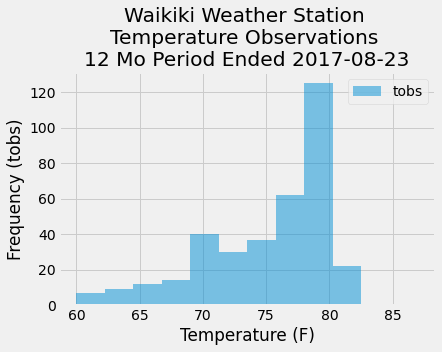

In [46]:
ax = lead_station_df.plot.hist(bins=12, alpha=0.5,
     title=f"{x} Weather Station \nTemperature Observations \n12 Mo Period Ended {end_date_str}"
     )

ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Frequency (tobs)")

### In the 2 cells below, we verified that the Upper Wahiawa, HI had no reported precipitation values for the most recent 1 year period, even though it had reporting such data previously.  We double checked by using both pandas-heavy and SQL-heavy methods.

### Our key finding is that there are literally no records whatsoever for these weather stations for the most recent 12-month period.  Zip.

In [47]:
# Upper Wahiawa, HI full period - pandas method
df.loc[df["station"] == "USC00518838"].head()

,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date
9007,USC00518838,2010-01-01,0.21,72.0,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6,2010-01-01
9008,USC00518838,2010-01-02,0.02,73.0,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6,2010-01-02
9009,USC00518838,2010-01-03,0.00,67.0,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6,2010-01-03
9010,USC00518838,2010-01-04,0.01,76.0,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6,2010-01-04
9011,USC00518838,2010-01-05,0.02,73.0,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6,2010-01-05


In [48]:
# Upper Wahiawa, HI most recent 12 months - pandas method
df.loc[(df["station"] == "USC00518838") & (df['dt date'] > yr_before_date)]

,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date


In [49]:
# Upper Wahiawa, HI most recent 12 months - SQL method
sql_upper_wahiawa_df = pd.read_sql("SELECT m.station, m.date, m.prcp, m.tobs, s.name, s.latitude, s.longitude, s.elevation \
                     FROM measurement m JOIN station s ON m.station = s.station \
                     WHERE m.date > '2016-08-23' AND m.station = 'USC00518838'", conn)
sql_upper_wahiawa_df["dt date"] = pd.to_datetime(sql_upper_wahiawa_df["date"])
sql_upper_wahiawa_df.head()

,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date


In [50]:
# Honolulu Observatory, HI full period - pandas method
df.loc[df["station"] == "USC00511918"].head()

,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date
14959,USC00511918,2010-01-01,0.05,66.0,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9,2010-01-01
14960,USC00511918,2010-01-02,0.00,70.0,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9,2010-01-02
14961,USC00511918,2010-01-03,0.00,75.0,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9,2010-01-03
14962,USC00511918,2010-01-04,0.00,75.0,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9,2010-01-04
14963,USC00511918,2010-01-05,0.00,75.0,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9,2010-01-05


In [51]:
# Honolulu Observatory, HI most recent 12 months - SQL method
df.loc[(df["station"] == "USC00511918") & (df['dt date'] > yr_before_date)]

,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date


In [52]:
# Honolulu Observatory, HI most recent 12 months - SQL method
sql_honolulu_observatory_df = pd.read_sql("SELECT m.station, m.date, m.prcp, m.tobs, s.name, s.latitude, s.longitude, s.elevation \
                     FROM measurement m JOIN station s ON m.station = s.station \
                     WHERE m.date > '2016-08-23' AND m.station = 'USC00511918'", conn)
sql_honolulu_observatory_df["dt date"] = pd.to_datetime(sql_honolulu_observatory_df["date"])
sql_honolulu_observatory_df.head()

,station,date,prcp,tobs,name,latitude,longitude,elevation,dt date


## Data Analysis Assignment - Part 1 - Capture Input and Make It Suitable for Querying

### Select a 2 week period to go on vacation to Hawaii

In [53]:
print(f"Hello!  Think of a 2 week vacation in beautiful Hawaii.\n")
vaca_start_date_str = input('Using the YYYY-MM-DD date format, enter your ideal vacation start date: ')

vaca_start_date = pd.to_datetime(vaca_start_date_str)
vaca_end_date = vaca_start_date + pd.offsets.DateOffset(weeks=2)
vaca_end_date_str = str(vaca_end_date).split(" ")[0]

weekday_vaca_start = calendar.day_name[vaca_start_date.weekday()]
weekday_vaca_end = calendar.day_name[vaca_end_date.weekday()]

month_vaca_start = vaca_start_date.strftime("%B")
year_vaca_start = vaca_start_date.strftime("%Y")

print(f"\nThank you!  You have chosen a 2 week fantasy vacation in Hawaii beginning in {month_vaca_start} {year_vaca_start}.")
print(f"We have scheduled you to arrive {weekday_vaca_start}, {vaca_start_date_str} and depart {weekday_vaca_end}, {vaca_end_date_str}.")

Hello!  Think of a 2 week vacation in beautiful Hawaii.

Using the YYYY-MM-DD date format, enter your ideal vacation start date: 2021-04-04

Thank you!  You have chosen a 2 week fantasy vacation in Hawaii beginning in April 2021.
We have scheduled you to arrive Sunday, 2021-04-04 and depart Sunday, 2021-04-18.


### Generate a DataFrame of previous-year dates corresponding to the upcoming vacation start and end dates

In [54]:
# Generate a list of years extracted from the data set
def createList(r1, r2): 
    return [item for item in range(r1, r2+1)] 
      
# "Drivers"
r1 = int(start_date_str.split("-")[0])
r2 = int(end_date_str.split("-")[0])

year_list = createList(r1, r2)

year_list = map(str, year_list)  
year_list = list(year_list)
year_list

['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

In [55]:
# Generate a list of dates of the upcoming scheduled vacation
vacation_dates_str = []

vacation_dates = pd.date_range(vaca_start_date,vaca_end_date-timedelta(days=1),freq='d')

for dates_y in vacation_dates:
    dates_y_str = dates_y.strftime("%Y-%m-%d")
    vacation_dates_str.append(dates_y_str)

vacation_dates_str_ser = pd.Series(vacation_dates_str)
vacation_dates_str_ser

0     2021-04-04
1     2021-04-05
2     2021-04-06
3     2021-04-07
4     2021-04-08
5     2021-04-09
6     2021-04-10
7     2021-04-11
8     2021-04-12
9     2021-04-13
10    2021-04-14
11    2021-04-15
12    2021-04-16
13    2021-04-17
dtype: object

In [56]:
val_Y = []
val_M = []
val_D = []

for dates_z in vacation_dates_str_ser:
    val_w = dates_z.split("-")
    val_Y.append(val_w[0])
    val_M.append(val_w[1])
    val_D.append(val_w[2])

val_YMD_dict = {"val_Y": val_Y, "val_M": val_M, "val_D": val_D}
val_YMD_df = pd.DataFrame(val_YMD_dict)
val_YMD_df["md_head"] = val_YMD_df['val_M'] + "-" + val_YMD_df['val_D']

val_YMD_df.head()

,val_Y,val_M,val_D,md_head
0,2021,04,04,04-04
1,2021,04,05,04-05
2,2021,04,06,04-06
3,2021,04,07,04-07
4,2021,04,08,04-08


In [57]:
# Create dictionary of empty lists, whose key's will be traversed as part of the query, and whose containers will capture data
annuals_list = val_YMD_df["md_head"]
annuals_dict = {annual:[] for annual in annuals_list}
annuals_dict

{'04-04': [],
 '04-05': [],
 '04-06': [],
 '04-07': [],
 '04-08': [],
 '04-09': [],
 '04-10': [],
 '04-11': [],
 '04-12': [],
 '04-13': [],
 '04-14': [],
 '04-15': [],
 '04-16': [],
 '04-17': []}

In [58]:
# Traverse the year list and a column of month-day values to create a list of historical annual dates corresponding 
# to the planned vacation dates

def add_element(annuals_dict, key, value):        # Define a function for appending the dictionary
    if key not in annuals_dict:
        annuals_dict[key] = []
    annuals_dict[key].append(value)    

for key in annuals_dict:

    for year in year_list:
        
        ndate = []                                # reset by clearing the date creator container
            
        ndate = f"{year}-{key}"                   # then slam together multiple years with the same month-day value
        
        add_element(annuals_dict, key, ndate)     # iteratively append the dictionary

z = pd.DataFrame(annuals_dict)                    # Convert the dictionary of lists into a dataframe

z                                                 # Preview the dataframe   

,04-04,04-05,04-06,04-07,04-08,04-09,04-10,04-11,04-12,04-13,04-14,04-15,04-16,04-17
0,2010-04-04,2010-04-05,2010-04-06,2010-04-07,2010-04-08,2010-04-09,2010-04-10,2010-04-11,2010-04-12,2010-04-13,2010-04-14,2010-04-15,2010-04-16,2010-04-17
1,2011-04-04,2011-04-05,2011-04-06,2011-04-07,2011-04-08,2011-04-09,2011-04-10,2011-04-11,2011-04-12,2011-04-13,2011-04-14,2011-04-15,2011-04-16,2011-04-17
2,2012-04-04,2012-04-05,2012-04-06,2012-04-07,2012-04-08,2012-04-09,2012-04-10,2012-04-11,2012-04-12,2012-04-13,2012-04-14,2012-04-15,2012-04-16,2012-04-17
3,2013-04-04,2013-04-05,2013-04-06,2013-04-07,2013-04-08,2013-04-09,2013-04-10,2013-04-11,2013-04-12,2013-04-13,2013-04-14,2013-04-15,2013-04-16,2013-04-17
4,2014-04-04,2014-04-05,2014-04-06,2014-04-07,2014-04-08,2014-04-09,2014-04-10,2014-04-11,2014-04-12,2014-04-13,2014-04-14,2014-04-15,2014-04-16,2014-04-17
5,2015-04-04,2015-04-05,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-11,2015-04-12,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17
6,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17
7,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17


### Create and populate a dataframe to store lists of values that will then be traversed in an iterative query

In [61]:
# List of date values for the first month-day pair (from start date), extracting first column from dataframe
previous_period_start_dates_list = z.iloc[:,0].tolist()
previous_period_start_dates_list

['2010-04-04',
 '2011-04-04',
 '2012-04-04',
 '2013-04-04',
 '2014-04-04',
 '2015-04-04',
 '2016-04-04',
 '2017-04-04']

In [62]:
# List of date values for the last month-day pair (from end date), extracting last column from dataframe
previous_period_end_dates_list = z.iloc[:,-1].tolist()
previous_period_end_dates_list

['2010-04-17',
 '2011-04-17',
 '2012-04-17',
 '2013-04-17',
 '2014-04-17',
 '2015-04-17',
 '2016-04-17',
 '2017-04-17']

In [63]:
# Traverse the year list to create a list of DataFrame names that will be used to capture data extracts
period_df_list = []

for year in year_list:
    period_df_name = f"t_{year}_df"
    period_df_list.append(period_df_name)

period_df_list

['t_2010_df',
 't_2011_df',
 't_2012_df',
 't_2013_df',
 't_2014_df',
 't_2015_df',
 't_2016_df',
 't_2017_df']

In [64]:
# Create a dataframe to serve up query values for an iterrows call
# This is the 2nd time we have done this in this exercise
previous_periods_dict = {"start_date": previous_period_start_dates_list,
                         "end_date": previous_period_end_dates_list,
                         "df_name": period_df_list,
                         "year": year_list}

query_2_df = pd.DataFrame.from_dict(previous_periods_dict)
query_2_df

,start_date,end_date,df_name,year
0,2010-04-04,2010-04-17,t_2010_df,2010
1,2011-04-04,2011-04-17,t_2011_df,2011
2,2012-04-04,2012-04-17,t_2012_df,2012
3,2013-04-04,2013-04-17,t_2013_df,2013
4,2014-04-04,2014-04-17,t_2014_df,2014
5,2015-04-04,2015-04-17,t_2015_df,2015
6,2016-04-04,2016-04-17,t_2016_df,2016
7,2017-04-04,2017-04-17,t_2017_df,2017


## Data Analysis Assignment - Part 2 - Capture and Process Data Needed for Analysis

### Capture the weather records for the 2 week period from each prior year in the data set
* Each year's data will initially be captured to its own DataFrame
* Then these individual year extracts will be merged back into a unified DataFrame

In [65]:
# Create and preview DataFrames for temperature and date data for the 2 week period from each prior year in the data set
for index, row in query_2_df.iterrows():

    row["df_name"] = df.loc[(df["date"] >= row["start_date"]) & (df["date"] <= row["end_date"])]
    # print(len(row["df_name"]))
    row['df_name'] = row['df_name'].sort_values(by=['date'])
    
    print(f"Preview of {row['year']} DataFrame:\n")
    print(row["df_name"].head())
    print(f"Rows = {len(row['df_name'])}")
    print()

Preview of 2010 DataFrame:

           station        date  prcp  tobs  \
81     USC00519397  2010-04-04  0.15  71.0   
9068   USC00518838  2010-04-04  0.87  66.0   
9611   USC00519523  2010-04-04  0.12  72.0   
2815   USC00513117  2010-04-04  0.13  71.0   
15047  USC00511918  2010-04-04  0.12  71.0   

                                     name  latitude  longitude  elevation  \
81                   WAIKIKI 717.2, HI US  21.27160 -157.81680        3.0   
9068           UPPER WAHIAWA 874.3, HI US  21.49920 -158.01110      306.6   
9611   WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139       19.5   
2815                 KANEOHE 838.1, HI US  21.42340 -157.80150       14.6   
15047   HONOLULU OBSERVATORY 702.2, HI US  21.31520 -157.99920        0.9   

         dt date  
81    2010-04-04  
9068  2010-04-04  
9611  2010-04-04  
2815  2010-04-04  
15047 2010-04-04  
Rows = 107

Preview of 2011 DataFrame:

           station        date  prcp  tobs                          name  \
41

In [66]:
# Create list of column names that will help to merge the DataFrames
on_list = ['date', 'dt date', 'station', 'name', 'prcp', 'tobs', 'latitude', 'longitude', 'elevation']

# Reminder: query_2_df.iloc[0,X] is referring to list of DataFrames created to hold iteratively extracted data
#           The query_2_df DataFrame was used to query for 2 weeks worth of data for the years 2010 through 2017
df005 = query_2_df.iloc[0,2].merge((query_2_df.iloc[1,2]), on=on_list, how='outer')
df005 = df005.merge((query_2_df.iloc[2,2]), on=on_list, how='outer')
df005 = df005.merge((query_2_df.iloc[3,2]), on=on_list, how='outer')
df005 = df005.merge((query_2_df.iloc[4,2]), on=on_list, how='outer')
df005 = df005.merge((query_2_df.iloc[5,2]), on=on_list, how='outer')
df005 = df005.merge((query_2_df.iloc[6,2]), on=on_list, how='outer')
df005 = df005.merge((query_2_df.iloc[7,2]), on=on_list, how='outer')

# Set the index (again) as the datetime-type column (vs. the string-type date column)
# Sort the dataframe on the string-type date column
df005.set_index("dt date", inplace=True)
df005.sort_values(by=["date"], inplace=True)

#Preview
df005.head()

,station,date,prcp,tobs,name,latitude,longitude,elevation
dt date,,,,,,,,
2010-04-04,USC00519397,2010-04-04,0.15,71.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2010-04-04,USC00518838,2010-04-04,0.87,66.0,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
2010-04-04,USC00519523,2010-04-04,0.12,72.0,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2010-04-04,USC00513117,2010-04-04,0.13,71.0,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2010-04-04,USC00511918,2010-04-04,0.12,71.0,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


### Verification and examination

In [67]:
# Verifying how many years records we are using for our analysis (8 in the data set - 2010-01 thru 2017-08)
# Verifying that we are examining for only 2 weeks records per each prior year (in this case 15 days)
# Calculating how many rows (records) we are using for our analysis
print("Prior years data for comparison")
print(f"Days per year = {df005['date'].nunique() / len(query_2_df['year'])}")
print(f"Years = {len(query_2_df['year'])}")
print(f"Total records being examined for comparison = {len(df005)}")

Prior years data for comparison
Days per year = 14.0
Years = 8
Total records being examined for comparison = 810


### Next, extract date and temperature values from the above prior-year-period weather records and reshape the output so that it is arranged by weather station
* Each year's data will initially be captured to its own DataFrame
* Then these individual year extracts will be merged back into a further new unified DataFrame

In [68]:
df005.reset_index(inplace=True)

# Create and preview DataFrames for temperature and date data from each weather station for the vacation period
for index, row in query_df.iterrows():
      
    row["DF Name List"] = df005[["date","dt date", "tobs"]].loc[df005["station"] == row["Station ID"]]
    row["DF Name List"] = row["DF Name List"].rename(columns={"tobs": f"{row['Station Name'].lower()} temp"})
    print(f"Preview of {row['Station Name']}:\n")
    print(row["DF Name List"].head())
    print(f"Rows = {len(row['DF Name List'])}")
    print()

Preview of Waikiki:

          date    dt date  waikiki temp
0   2010-04-04 2010-04-04          71.0
8   2010-04-05 2010-04-05          72.0
22  2010-04-06 2010-04-06          75.0
33  2010-04-08 2010-04-08          75.0
44  2010-04-09 2010-04-09          75.0
Rows = 109

Preview of Kaneohe:

          date    dt date  kaneohe temp
3   2010-04-04 2010-04-04          71.0
11  2010-04-05 2010-04-05          71.0
23  2010-04-06 2010-04-06          69.0
26  2010-04-07 2010-04-07          70.0
38  2010-04-08 2010-04-08          73.0
Rows = 111

Preview of Kualoa Ranch Headquarters:

          date    dt date  kualoa ranch headquarters temp
7   2010-04-04 2010-04-04                            70.0
12  2010-04-05 2010-04-05                            70.0
19  2010-04-06 2010-04-06                            70.0
30  2010-04-07 2010-04-07                            71.0
36  2010-04-08 2010-04-08                            72.0
Rows = 101

Preview of Pearl City:

           date    dt date  pea

In [127]:
# Create dataframe merging the individual weather station dataframes temperature data on date
# Reminder: The query_df DataFrame was used to query for data for one weather station at a time
df006 = (query_df.iloc[0,2]).merge((query_df.iloc[1,2]), on=['date', 'dt date'], how='outer')
df006 = df006.merge((query_df.iloc[2,2]), on=['date', 'dt date'], how='outer')
df006 = df006.merge((query_df.iloc[3,2]), on=['date', 'dt date'], how='outer')
df006 = df006.merge((query_df.iloc[4,2]), on=['date', 'dt date'], how='outer')
df006 = df006.merge((query_df.iloc[5,2]), on=['date', 'dt date'], how='outer')
df006 = df006.merge((query_df.iloc[6,2]), on=['date', 'dt date'], how='outer')
df006 = df006.merge((query_df.iloc[7,2]), on=['date', 'dt date'], how='outer')
df006 = df006.merge((query_df.iloc[8,2]), on=['date', 'dt date'], how='outer')

# Set the index (again) as the datetime-type column (vs. the string-type date column)
# Sort the dataframe on the string-type date column
df006.set_index("dt date", inplace=True)
df006.sort_values(by=["date"], inplace=True)

#Preview
df006.head()

,date,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp
dt date,,,,,,,,,,
2010-04-04,2010-04-04,71.0,71.0,70.0,NaN,66.0,72.0,71.0,71.0,67.0
2010-04-05,2010-04-05,72.0,71.0,70.0,NaN,67.0,72.0,71.0,73.0,69.0
2010-04-06,2010-04-06,75.0,69.0,70.0,NaN,70.0,73.0,69.0,70.0,69.0
2010-04-07,2010-04-07,NaN,70.0,71.0,NaN,72.0,73.0,69.0,71.0,68.0
2010-04-08,2010-04-08,75.0,73.0,72.0,NaN,74.0,73.0,72.0,68.0,76.0


In [128]:
# Add a month-day identifier column that can then be grouped

val_md_set = []

dates_p_set = df006["date"]

for date_p in dates_p_set:
    val_set = date_p.split("-")
    val_md = val_set[1] + "-" + val_set[2]
    val_md_set.append(val_md)

df006.insert(loc=1, column='md', value=val_md_set)

# Use the month-day identifier column to perform groupby aggregated calculations - Average Temperature
md_vaca_temp_avg = df006.groupby("md").mean()
md_vaca_temp_avg_df = pd.DataFrame(md_vaca_temp_avg)
print(f"\nRows = {len(md_vaca_temp_avg_df)}")

# Preview
md_vaca_temp_avg_df.head()


Rows = 14


,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp
md,,,,,,,,,
04-04,73.375000,72.375,73.285714,73.500000,71.666667,74.875000,71.125,66.200000,69.875000
04-05,74.000000,71.500,73.857143,73.000000,69.666667,74.714286,71.375,70.600000,70.375000
04-06,73.125000,70.500,72.714286,72.000000,69.500000,72.625000,70.875,71.833333,69.333333
04-07,73.142857,70.875,72.285714,72.000000,71.000000,73.000000,69.750,69.333333,68.571429
04-08,74.000000,71.000,73.333333,74.333333,70.666667,73.142857,71.500,70.166667,71.250000


In [123]:
# Use the month-day identifier column to perform groupby aggregated calculations - Average Temperature
md_vaca_temp_avg = df006.groupby("md").mean()
md_vaca_temp_avg_df = pd.DataFrame(md_vaca_temp_avg)
print(f"\nRows = {len(md_vaca_temp_avg_df)}")
md_vaca_temp_avg_df.head()


Rows = 14


,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp
md,,,,,,,,,
04-04,73.375000,72.375,73.285714,73.500000,71.666667,74.875000,71.125,66.200000,69.875000
04-05,74.000000,71.500,73.857143,73.000000,69.666667,74.714286,71.375,70.600000,70.375000
04-06,73.125000,70.500,72.714286,72.000000,69.500000,72.625000,70.875,71.833333,69.333333
04-07,73.142857,70.875,72.285714,72.000000,71.000000,73.000000,69.750,69.333333,68.571429
04-08,74.000000,71.000,73.333333,74.333333,70.666667,73.142857,71.500,70.166667,71.250000


In [124]:
list_avg_temps = []

for index, row in md_vaca_temp_avg.iterrows():
    q = row.iloc[0:8].mean(skipna=True)
    list_avg_temps.append(q)

list_avg_temps

[72.05029761904763,
 72.33913690476192,
 71.64657738095238,
 71.4233630952381,
 72.26785714285714,
 71.68898809523809,
 71.66496598639455,
 72.84479166666667,
 72.840625,
 72.00520833333333,
 73.234375,
 71.76116071428571,
 71.55208333333334,
 71.34375]

In [125]:
insert_idx_value = len(md_vaca_temp_avg_df.columns)
insert_idx_value

9

In [126]:
md_vaca_temp_avg_df.insert(loc=insert_idx_value, column='Avg Across All Stations', value=list_avg_temps)
md_vaca_temp_avg_df.head()

,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp,Avg Across All Stations
md,,,,,,,,,,
04-04,73.375000,72.375,73.285714,73.500000,71.666667,74.875000,71.125,66.200000,69.875000,72.050298
04-05,74.000000,71.500,73.857143,73.000000,69.666667,74.714286,71.375,70.600000,70.375000,72.339137
04-06,73.125000,70.500,72.714286,72.000000,69.500000,72.625000,70.875,71.833333,69.333333,71.646577
04-07,73.142857,70.875,72.285714,72.000000,71.000000,73.000000,69.750,69.333333,68.571429,71.423363
04-08,74.000000,71.000,73.333333,74.333333,70.666667,73.142857,71.500,70.166667,71.250000,72.267857


In [92]:
md_vaca_temp_high = df006.groupby("md").max()
md_vaca_temp_high

,date,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp
md,,,,,,,,,,
04-04,2017-04-04,76.0,78.0,78.0,76.0,75.0,78.0,74.0,72.0,75.0
04-05,2017-04-05,78.0,74.0,77.0,78.0,73.0,80.0,76.0,76.0,74.0
04-06,2017-04-06,77.0,73.0,76.0,73.0,70.0,77.0,76.0,76.0,72.0
04-07,2017-04-07,77.0,74.0,76.0,76.0,72.0,78.0,75.0,74.0,71.0
04-08,2017-04-08,77.0,73.0,77.0,76.0,74.0,77.0,77.0,77.0,76.0
04-09,2017-04-09,76.0,74.0,77.0,74.0,71.0,76.0,78.0,77.0,75.0
04-10,2017-04-10,78.0,74.0,79.0,75.0,NaN,76.0,75.0,76.0,72.0
04-11,2017-04-11,79.0,75.0,78.0,76.0,75.0,82.0,74.0,77.0,73.0
04-12,2017-04-12,78.0,74.0,77.0,76.0,74.0,80.0,74.0,75.0,72.0


In [93]:
md_vaca_temp_low = df006.groupby("md").min()
md_vaca_temp_low

,date,waikiki temp,kaneohe temp,kualoa ranch headquarters temp,pearl city temp,upper wahiawa temp,waimanalo experimental farm temp,waihee temp,honolulu observatory temp,manoa lyon arbo temp
md,,,,,,,,,,
04-04,2010-04-04,68.0,65.0,70.0,71.0,66.0,72.0,67.0,58.0,66.0
04-05,2010-04-05,71.0,69.0,70.0,70.0,67.0,72.0,65.0,61.0,69.0
04-06,2010-04-06,69.0,67.0,70.0,71.0,69.0,67.0,67.0,70.0,67.0
04-07,2010-04-07,70.0,67.0,67.0,69.0,70.0,67.0,65.0,63.0,66.0
04-08,2010-04-08,70.0,68.0,69.0,71.0,68.0,69.0,67.0,68.0,66.0
04-09,2010-04-09,72.0,69.0,68.0,70.0,69.0,71.0,68.0,62.0,64.0
04-10,2010-04-10,69.0,67.0,65.0,68.0,NaN,69.0,65.0,64.0,64.0
04-11,2010-04-11,71.0,68.0,68.0,71.0,67.0,68.0,65.0,66.0,67.0
04-12,2010-04-12,69.0,70.0,70.0,73.0,74.0,71.0,65.0,66.0,65.0


## Data Analysis Assignment - Part 3 - Analyze Data and Generate Results and Set (Name) as Variables

### Calculate average temperature (tobs) across all weather stations for each day - For All Month-Day Prior Years Periods

In [ ]:
# Calculate average TOBS for all weather stations
average = []
date2 = []

for index, row in df006.iterrows():
    y = row.iloc[1:9].mean(skipna=True)
    average.append(y)
    date2.append(row["date"])
    
print(f"Values count for the mean calculation list {len(average)}")
print(f"Values count for the date list {len(date2)}")

In [ ]:
avg_dict = {"date": date2, "average": average}
df007 = pd.DataFrame(avg_dict)
df007.head()

In [ ]:
# Add average column to the larger dataframe
df006["average"] = df007["average"].tolist()
df006.head()

### Summary statistics for the temperature observations (tobs) data - For All Month-Day Prior Years Periods

In [ ]:
# Use Pandas to calculate the summary statistics for the temperature data
df_description3 = df006.describe(include=[np.number])
df_description3 = pd.DataFrame(df_description3)
df_description3.rename(columns={"average": "Avg Across All Stations"}, inplace=True)
df_description3

In [ ]:
TMIN = df_description3.iloc[3,9]
TMAX = df_description3.iloc[7,9]
TAVG = df_description3.iloc[1,9]

print(f"For the Hawaiian Islands, the historical average low temperature for the period is {round(TMIN, 1)}F.")
print(f"For the Hawaiian Islands, the historical average high temperature for the period is {round(TMAX, 1)}F.")
print(f"For the Hawaiian Islands, the historical average temperature for the period is {round(TAVG, 1)}F.")
print(f"\nAll figures reported above are calculated from an daily average across all Hawaiian Island weather stations.")

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(vaca_start_date, vaca_end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        # vaca_start_date_str (string): A date string in the format %Y-%m-%d
        # vaca_end_date_str (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    # your code here
    
    return # your code here

print(calc_temps('2012-02-28', '2012-03-05'))


# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    
    # your code here
    
    return # your code here
    
daily_normals("01-01")

In [ ]:
df006

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
